In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import random
import numpy as np
import tensorflow as tf
import cv2

Tải lên dữ liệu đã trích rút

In [2]:
path="D:/HCSDLDPT/HCSDLDPT_birds_classification/"
path_bird_data= path+"bird_data.npy"
path_rgb=path+"bird_RGB.npy"
path_hsv=path+"bird_HSV.npy"
path_hog=path+"bird_HOG.npy"
path_hog_hsv=path+"concat_hog_hsv.npy"
path_hog_rgb=path+"concat_hog_rgb.npy"

In [3]:
import numpy as np
# Load the NumPy file
flower_data = np.load(path_bird_data, allow_pickle="True")
data_RGB = np.load(path_rgb,allow_pickle="True")
data_HSV = np.load(path_hsv ,allow_pickle="True")
data_HOG = np.load(path_hog , allow_pickle="True")
data_HOG_HSV=np.load(path_hog_hsv, allow_pickle="True")
data_HOG_RGB=np.load(path_hog_rgb, allow_pickle="True")

Test đầu vào


In [4]:
#This function converts an RGB pixel value to an HSV color model
def rgb_to_hsv(pixel):
    # Extract red, green and blue values from input pixel.then Normalize the RGB values by dividing with 255.0 to get values between 0 and 1
    r, g, b = pixel
    r, g, b = b / 255.0, g / 255.0, r / 255.0

    # Find the maximum and minimum value among R, G, and B values
    v = max(r, g, b)
    delta = v - min(r, g, b)

    # If there is no difference between the maximum and minimum value, saturation and hue are set to zero
    if delta == 0:
        h = 0
        s = 0
    else:
        # Calculate the saturation value
        s = delta / v
        
        # Calculate the hue value
        if r == v:
            h = (g - b) / delta
        elif g == v:
            h = 2 + (b - r) / delta
        else:
            h = 4 + (r - g) / delta
        # Normalize the hue value to be between 0 and 1 and convert it to degrees
        h = (h / 6) % 1.0

    # Convert the hue, saturation, and value values from float to integer values within the ranges of 0-180, 0-255, and 0-255 respectively
    return [int(h * 180), int(s * 255), int(v * 255)]

#This function takes an RGB image as input and converts it to an HSV color model
def covert_image_rgb_to_hsv(img):
    # Create an empty array to hold the converted HSV image
    hsv_image = []

    # Loop through each pixel in the image
    for i in img:
        # Create an empty array to hold the converted HSV values of each pixel
        hsv_image2 = []
        for j in i:
            # Convert each RGB pixel value to its HSV equivalent using the rgb_to_hsv() function
            new_color = rgb_to_hsv(j)
            hsv_image2.append((new_color))
        # Add the converted HSV values of each pixel to the array that holds the converted HSV image
        hsv_image.append(hsv_image2)

    # Convert the list of lists to a numpy array and return the final HSV image
    hsv_image = np.array(hsv_image)
    return hsv_image

#This function calculates a histogram of an input image based on the specified channels, histogram size and ranges
def my_calcHist(image, channels, bins, ranges):
    # Initialize a numpy array to hold the histogram counts for each bin
    hist = np.zeros(bins, dtype=np.int64)

    # Loop through every pixel in the image
    for i in range(image.shape[0]):
        for j in range(image.shape[1]):
            # Extract the pixel values for the specified color channels
            bin_vals = [image[i, j, c] for c in channels]
            
            # Calculate the bin indices (bin_idxs) for each channel based on the pixel values and the range of possible pixel values 
            bin_idxs = [
                (bin_vals[c] - ranges[c][0]) * bins[c]
                // (ranges[c][1] - ranges[c][0])
                for c in range(len(channels))
            ]
            
            # Increment the count of the corresponding bin by 1
            hist[tuple(bin_idxs)] += 1

    # Return the final histogram as a numpy array
    return hist

In [5]:
from skimage import feature
import cv2

#This function converts an RGB image to a grayscale image using the formula Y = 0.299R + 0.587G + 0.114B
def convert_image_rgb_to_gray(img_rgb, resize="no"):
    # Get the height (h), width (w), and number of channels (_) of the input RGB image
    h, w, _ = img_rgb.shape

    # Create an empty numpy array of zeros with dimensions (h, w) to hold the converted grayscale values
    img_gray = np.zeros((h, w), dtype=np.uint32)

    # Convert each pixel from RGB to grayscale using the formula Y = 0.299R + 0.587G + 0.114B
    for i in range(h):
        for j in range(w):
            r, g, b = img_rgb[i, j]
            gray_value = int(0.299 * r + 0.587 * g + 0.114 * b)
            img_gray[i, j] = gray_value
        
    # If the resize flag is specified, resize the grayscale image to dimensions of (496, 496)
    if resize != "no":
        img_gray = cv2.resize(src=img_gray, dsize=(496, 496))

    # Return the final grayscale image as a numpy array
    return np.array(img_gray)


def hog_feature(gray_img):  # default gray_image
    # Compute the HOG features and the HOG visualization image using the scikit-image "feature" module's hog() function.
    (hog_feats, hogImage) = feature.hog(
        gray_img,
        orientations=9,
        pixels_per_cell=(8, 8),
        cells_per_block=(2, 2),
        transform_sqrt=True,
        block_norm="L2",
        visualize=True,
    )

    # Return the HOG feature descriptor as a numpy array
    return hog_feats

In [6]:
#This is a Python function that extracts features from an RGB image using
#Histogram of Oriented Gradients (HOG) and a 3D color histogram in HSV color space.
def feature_extraction(img):  # RGB image
    bins = [8, 12, 3]
    ranges = [[0, 180], [0, 256], [0, 256]]
    img_hsv = covert_image_rgb_to_hsv(img)
    hist_my = my_calcHist(img_hsv, [0, 1, 2], bins, ranges)
    embedding_hsv = list(hist_my.flatten())
    embedding_hsv[0] = 0

    gray_image = convert_image_rgb_to_gray(img)
    embedding_hog = list(hog_feature(gray_image))

    data = embedding_hsv + embedding_hog
    return data

Hàm KNN


In [7]:
import math

# Hàm tính khoảng cách Euclidean giữa hai vectơ x và y
def distance_euclidean(x, y):
    if len(x) != len(y):
        return None  # Invalid input
    squared_distance = sum((xi - yi) ** 2 for xi, yi in zip(x, y))
    return math.sqrt(squared_distance)

# Hàm thực hiện phân loại k-Nearest Neighbors (k-NN) trên điểm dữ liệu mới x_new,
# Được cung cấp tập dữ liệu huấn luyện X_train và nhãn tương ứng y_train
# Tìm k điểm gần nhất
def knn(X_train, y_train, img_paths, x_new, k):
    distances = []
    for i in range(len(X_train)):
        d = distance_euclidean(X_train[i], x_new)
        distances.append((d, y_train[i], img_paths[i]))
    distances.sort()
    k_nearest = distances[:k]
    
    # Dự đoán nhãn cho điểm dữ liệu mới
    labels = {}
    for distance in k_nearest:
        label = distance[1]
        if label in labels:
            labels[label] += 1
        else:
            labels[label] = 1
    sorted_labels = sorted(labels.items(), key=lambda x: x[1], reverse=True)
    
    # Trả về nhãn dự đoán và danh sách các điểm gần nhất
    predicted_label = sorted_labels[0][0] if sorted_labels else None
    return predicted_label, k_nearest

In [8]:
#data_HOG_HSV
X_HOG_HSV=[] ; y_HOG_HSV=[]; img_paths=[];
for i in data_HOG_HSV:
    img_paths.append(i[2])
    X_HOG_HSV.append(i[1])
    y_HOG_HSV.append(i[0])

In [9]:
dict={'0': 'ABBOTTS BABBLER', '1': 'AFRICAN FIREFINCH', '2': 'ALBERTS TOWHEE', '3': 'AMERICAN AVOCET', '4': 'AMERICAN PIPIT', '5': 'AMERICAN REDSTART', '6': 'AMERICAN ROBIN', '7': 'ANDEAN LAPWING', '8': 'BANDED PITA', '9': 'BLACK THROATED WARBLER', '10': 'BLOOD PHEASANT', '11': 'CAPE GLOSSY STARLING', '12': 'CEDAR WAXWING', '13': 'EASTERN BLUEBIRD', '14': 'GOLDEN PIPIT', '15': 'GREEN BROADBILL', '16': 'HAWFINCH', '17': 'HIMALAYAN BLUETAIL', '18': 'HOOPOES', '19': 'HOUSE FINCH', '20': 'INDIAN PITTA', '21': 'IWI', '22': 'LARK BUNTING', '23': 'LESSER ADJUTANT', '24': 'MYNA', '25': 'NORTHERN PARULA', '26': 'OCELLATED TURKEY', '27': 'ORANGE BREASTED TROGON', '28': 'ORANGE BRESTED BUNTING', '29': 'OSPREY', '30': 'OSTRICH', '31': 'OVENBIRD', '32': 'OYSTER CATCHER', '33': 'PAINTED BUNTING', '34': 'PALILA', '35': 'PARUS MAJOR', '36': 'PATAGONIAN SIERRA FINCH', '37': 'PEACOCK', '38': 'PEREGRINE FALCON', '39': 'PHAINOPEPLA', '40': 'PURPLE FINCH', '41': 'PURPLE MARTIN', '42': 'PYGMY KINGFISHER', '43': 'PYRRHULOXIA', '44': 'RAINBOW LORIKEET', '45': 'RAZORBILL', '46': 'RED BELLIED PITTA', '47': 'RED CROSSBILL', '48': 'RED FACED WARBLER', '49': 'RED FODY', '50': 'RED HEADED WOODPECKER', '51': 'RED LEGGED HONEYCREEPER', '52': 'RED SHOULDERED HAWK', '53': 'RED WISKERED BULBUL', '54': 'REGENT BOWERBIRD', '55': 'ROCK DOVE', '56': 'ROSE BREASTED GROSBEAK', '57': 'ROSEATE SPOONBILL', '58': 'RUFOUS KINGFISHER'}

In [10]:
path_datatest=r"D:/HCSDLDPT/HCSDLDPT_birds_classification/Test_Image/"
os.listdir(path_datatest)

['chich_bong.jpg',
 'chim_sau_bung_vang.jpg',
 'co_quam_do.jpg',
 'sao_lung_tim.jpg',
 'Sao_nau.jpg',
 'Test_data.jpg']

In [11]:
import os
from rembg import remove
from PIL import Image
import io

In [14]:
input_image_path = "D:\\HCSDLDPT\\HCSDLDPT_birds_classification\\Bird_dataset_OZ_1_2\\Chich_lung_xanh_Himalaya\\1.jpg"

In [15]:
# Đường dẫn đến file kết quả
output_image_path = "D:\HCSDLDPT\HCSDLDPT_birds_classification\Test_Image\Test_data.jpg"

# Đảm bảo thư mục đích tồn tại
output_folder = os.path.dirname(output_image_path)
if not os.path.exists(output_folder):
    os.makedirs(output_folder)
# Mở ảnh từ file
with Image.open(input_image_path) as img:
    # Kiểm tra xem ảnh có kênh alpha hay không
    if img.mode == "RGBA":
        print("Ảnh đã loại bỏ nền, bỏ qua bước này.")
        output_image = img
    else:
        # Xử lý ảnh để loại bỏ nền
        with open(input_image_path, 'rb') as i:
            input_data = i.read()
            output_data = remove(input_data)
        # Mở ảnh sau khi xóa nền từ bộ nhớ
        output_image = Image.open(io.BytesIO(output_data))

# Mở ảnh sau khi xóa nền từ bộ nhớ
output_image = Image.open(io.BytesIO(output_data))

# Thay đổi kích thước ảnh sao cho một trong hai chiều bằng 224, giữ nguyên tỷ lệ khung hình
max_size = 224
output_image.thumbnail((max_size, max_size), Image.ANTIALIAS)

# Tạo một ảnh mới kích thước 224x224 với nền đen (vì JPEG không hỗ trợ kênh alpha)
square_image = Image.new("RGB", (224, 224), (0, 0, 0))

# Tính toán vị trí để dán ảnh vào giữa ảnh hình vuông
paste_x = (224 - output_image.width) // 2
paste_y = (224 - output_image.height) // 2

# Dán ảnh đã thay đổi kích thước vào giữa ảnh 224x224
square_image.paste(output_image.convert("RGB"), (paste_x, paste_y))

# Lưu ảnh kết quả ra file dưới định dạng JPEG
square_image.save(output_image_path, format="JPEG")

C:\Users\Anthony tis\AppData\Local\Temp\ipykernel_14032\2387744943.py:27: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  output_image.thumbnail((max_size, max_size), Image.ANTIALIAS)


26532
D:\HCSDLDPT\HCSDLDPT_birds_classification\Bird_dataset_OZ_1_2\Son_ca_mien_Dong\1.jpg
2021.424320824956


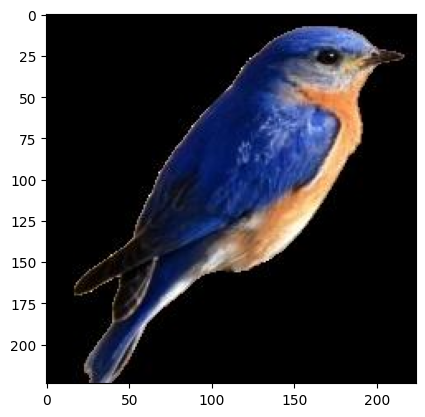

D:\HCSDLDPT\HCSDLDPT_birds_classification\Bird_dataset_OZ_1_2\Chich_xanh_hong_den\4.jpg
2252.42381887835


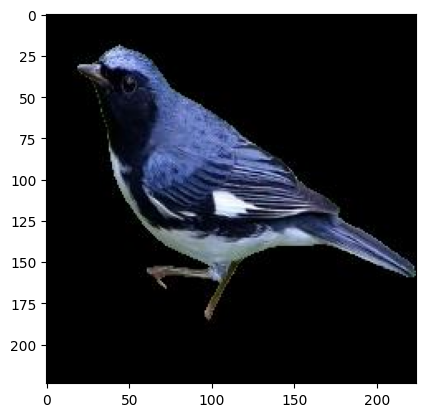

D:\HCSDLDPT\HCSDLDPT_birds_classification\Bird_dataset_OZ_1_2\Chich_lung_xanh_Himalaya\2.jpg
2317.2957216230943


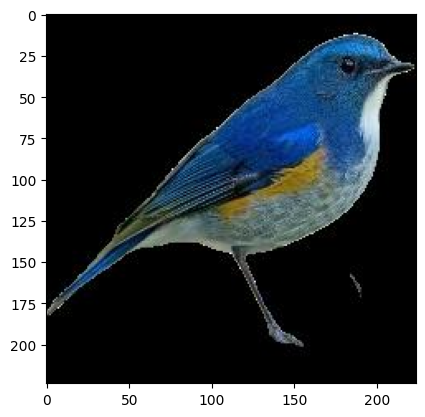

In [16]:
img = cv2.imread(output_image_path, cv2.COLOR_BGR2RGB)
img_embedding = feature_extraction(img)
print(len(img_embedding))

# Gọi hàm knn với các tham số cần thiết
predicted_label, res = knn(X_HOG_HSV, y_HOG_HSV, img_paths, img_embedding, 7)

# Lấy 4 kết quả tốt nhất
top_results = res[:4]
# In ra 4 kết quả tốt nhất
count = 0
for result in top_results:
    img_path = result[2]  # Assuming result[2] contains the path to the image
    if img_path == input_image_path:
        continue
    else:
        print(img_path)
        print(result[0])
        img = cv2.imread(img_path)  # Read the image
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB
        plt.imshow(img)  # Display the image
        plt.show()  # Show the image
        count += 1
        if count == 3: break